# Experiments

Running experiments to demonstrate bias-variance tradeoff for neural networks.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

x = torch.linspace(-10, 10, 1000)
y = 3 * torch.sin(x) + torch.cos(torch.pi * x)


def model(width, sample_size, alpha=0.0, x=x, y=y):
    """Fitting a wide fully connected ReLU network."""
    
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    N = torch.randint(0, 1000, size=(sample_size,))
    N = torch.sort(N)[0]
    xs = x[N]
    ys = y[N]

    net = nn.Sequential(
        nn.Linear(1, width),
        nn.Tanh(),
        nn.Linear(width, 1)
    )
    theta = net.parameters()
    optim = torch.optim.Adam(theta, lr=0.1, weight_decay=alpha)

    for _ in range(100):
        loss = F.mse_loss(ys, net(xs))
        loss.backward()
        optim.step()
        optim.zero_grad()

    return net(x).reshape(-1).detach().cpu().numpy()


def variance(sample_preds):
    p_bar = sum(sample_preds) / len(sample_preds)
    return sum([((p_bar - p) ** 2).mean() for p in sample_preds]) / len(sample_preds)

def bias(sample_preds):
    p_bar = sum(sample_preds) / len(sample_preds)
    return ((p_bar - y.numpy()) ** 2).mean()

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt


def reset_seed():
    np.random.seed(0)
    torch.manual_seed(0)

def plot_model(ax, width=6, sample_size=6, alpha=0.0, count=300):
    sample_preds = []
    for i in range(count):
        p = model(width, sample_size, alpha)
        if i < 100:
            ax.plot(x, p, alpha=0.5, color="C0")
        sample_preds.append(p)
    
    var = variance(sample_preds)
    b = bias(sample_preds)

    title = f"var={var:.2f}, bias={b:.2f} \n width={width}, n={sample_size}"
    if alpha > 0:
        title += f", $\lambda$={alpha:.0e}"
    
    ax.set_title(title)
    ax.plot(x, y, color="black", linewidth=2)
    ax.set_ylim(-8, 8)

Decreasing model complexity decreases variance:

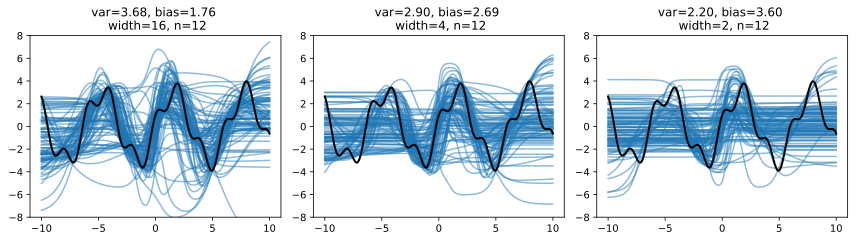

In [3]:
reset_seed()
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
plot_model(ax[0], width=16, sample_size=12)
plot_model(ax[1], width=4,  sample_size=12)
plot_model(ax[2], width=2,  sample_size=12)
fig.tight_layout()

More data decreases variance so that bias dominates:

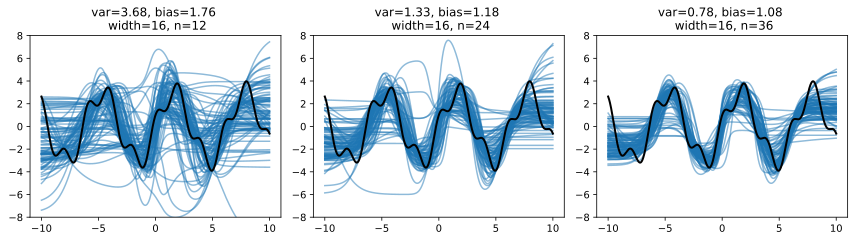

In [4]:
reset_seed()
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
plot_model(ax[0], width=16, sample_size=12)
plot_model(ax[1], width=16, sample_size=24)
plot_model(ax[2], width=16, sample_size=36)
fig.tight_layout()

Regularization decreases variance and increases bias:

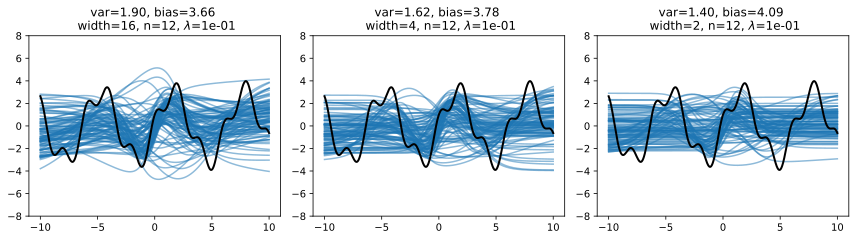

In [5]:
reset_seed()
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
plot_model(ax[0], width=16, sample_size=12, alpha=0.1)
plot_model(ax[1], width=4,  sample_size=12, alpha=0.1)
plot_model(ax[2], width=2,  sample_size=12, alpha=0.1)
fig.tight_layout()

Regularization decreases complexity such that the model underfits:

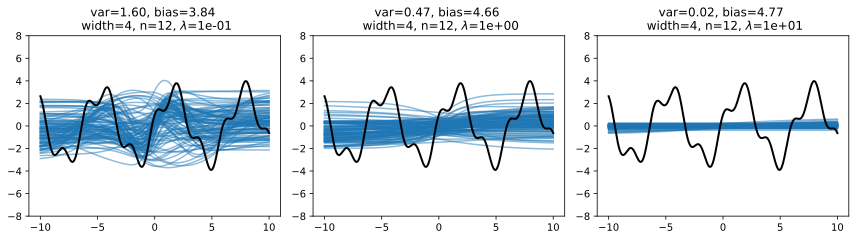

In [6]:
reset_seed()
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
plot_model(ax[0], width=4, sample_size=12, alpha=0.1)
plot_model(ax[1], width=4, sample_size=12, alpha=1.0)
plot_model(ax[2], width=4, sample_size=12, alpha=10.0)
fig.tight_layout()

**Remark.** Notice that complex models benefit more with regularization and scale better with data compared to simple models. The experiments show that starting with complex models followed by regularization is a valid approach.